In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None

In [24]:
import nltk
nltk.__version__

'3.4.5'

In [25]:
data = pd.read_csv('tweet-sentiment-extraction/sample_submission.csv')
test = pd.read_csv('tweet-sentiment-extraction/test.csv')
train = pd.read_csv('tweet-sentiment-extraction/train.csv',encoding='utf-8-sig')

In [26]:
display(test.head(1))
print(test.shape)
print(test.isnull().sum())
display(train.tail(1))
print(train.shape)
print(train.isnull().sum())

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive


(3535, 3)
textID       0
text         0
sentiment    0
dtype: int64


,textID,text,selected_text,sentiment
27485,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


(27486, 4)
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [27]:
train = train.dropna().reset_index(drop = True)
print(train.shape)
print(train.isnull().sum())
display(train.tail(1))

(27485, 4)
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


,textID,text,selected_text,sentiment
27484,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


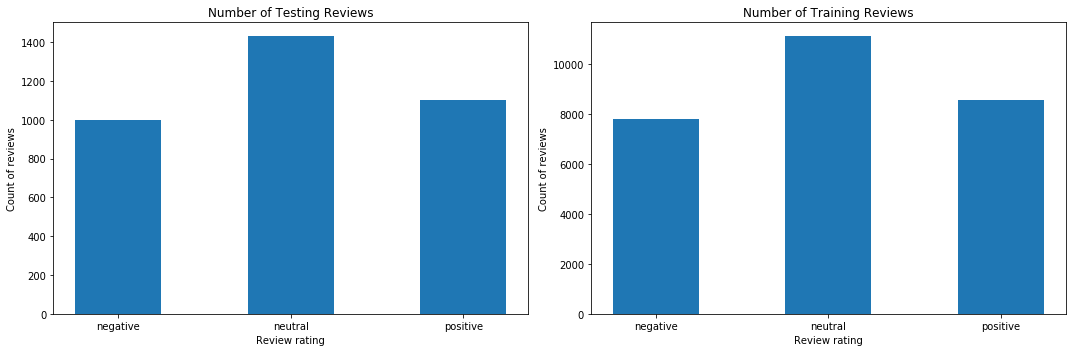

In [28]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

test_values, test_counts = np.unique(test['sentiment'], return_counts = True)
ax[0].bar(test_values, test_counts, width = 0.5)
ax[0].set_xlabel('Review rating')
ax[0].set_ylabel('Count of reviews')
ax[0].set_title('Number of Testing Reviews')


train_values, train_counts = np.unique(train['sentiment'], return_counts = True)
ax[1].bar(train_values, train_counts, width = 0.5)
ax[1].set_xlabel('Review rating')
ax[1].set_ylabel('Count of reviews')
ax[1].set_title('Number of Training Reviews')

plt.tight_layout()

In [29]:
train['sentiment'] = train['sentiment'].map({"negative":0, "neutral":1, 'positive':2})
train.head(5)

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2


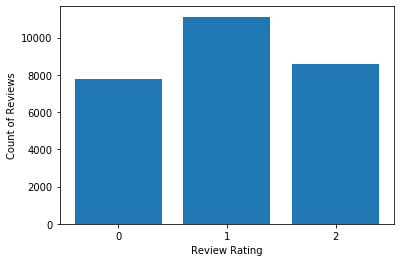

In [30]:
values, counts = np.unique(train['sentiment'], return_counts=True)
plt.figure()
plt.bar(["0","1",'2'], counts)
plt.xlabel('Review Rating')
plt.ylabel('Count of Reviews')
plt.show()

In [31]:
print(counts/np.sum(counts))

[0.28328179 0.40447517 0.31224304]


# Cleaning

In [32]:
text = train["text"][1353]
text

'_mraz http://twitpic.com/4iq19 - popcorn crazy dude and still adorable'

In [33]:
def remove_url(text):
    del_url = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    return del_url

In [34]:
clean_text = []
for text in (train['text']):
    remove = remove_url(text)
    clean_text.append(remove)
clean_text

['Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.  I had other plans for my morning',
 ' Oh! Good idea about putting them on ice cream',
 'says good (or should i say bad?) afternoon!   ',
 ' i dont think you can vote anymore! i tried',
 ' haha better drunken tweeting you mean?',
 'headache  wanna see my Julie',
 'had an awsome salad! I recommend getting the Spicey buffalo chicken salad!',
 ' fine! Going to do my big walk today 20 or so miles',
 ' Thank a yoou  how are you? #TwitterTakeover',
 "Why don't adobe realise no one WANTS to pay for Photoshop et al so they should just give it to us for free",
 'PRD take a long time to review!',
 '_2008 Well, having to revise them!  Was to do some more gardening, now, I guess hoovering and some warcraft  Not played in a week !',
 ' Miss you my dear',
 'Have just bought a TV tuner for my laptop.  He he.  I deserve a present',
 ' ya mine too but for very different reason',
 'Today Dan bought me Bi

In [37]:
def tokenizer(text):
    tokens = word_tokenize(text)
    return tokens

In [38]:
clean_text = []
for text in (train['text']):
    remove = tokenizer(text)
    clean_text.append(remove)
clean_text

[['Spent',
  'the',
  'entire',
  'morning',
  'in',
  'a',
  'meeting',
  'w/',
  'a',
  'vendor',
  ',',
  'and',
  'my',
  'boss',
  'was',
  'not',
  'happy',
  'w/',
  'them',
  '.',
  'Lots',
  'of',
  'fun',
  '.',
  'I',
  'had',
  'other',
  'plans',
  'for',
  'my',
  'morning'],
 ['Oh', '!', 'Good', 'idea', 'about', 'putting', 'them', 'on', 'ice', 'cream'],
 ['says',
  'good',
  '(',
  'or',
  'should',
  'i',
  'say',
  'bad',
  '?',
  ')',
  'afternoon',
  '!',
  'http',
  ':',
  '//plurk.com/p/wxpdj'],
 ['i', 'dont', 'think', 'you', 'can', 'vote', 'anymore', '!', 'i', 'tried'],
 ['haha', 'better', 'drunken', 'tweeting', 'you', 'mean', '?'],
 ['headache', 'wan', 'na', 'see', 'my', 'Julie'],
 ['had',
  'an',
  'awsome',
  'salad',
  '!',
  'I',
  'recommend',
  'getting',
  'the',
  'Spicey',
  'buffalo',
  'chicken',
  'salad',
  '!'],
 ['fine',
  '!',
  'Going',
  'to',
  'do',
  'my',
  'big',
  'walk',
  'today',
  '20',
  'or',
  'so',
  'miles'],
 ['Thank', 'a', 'yoou

In [39]:
stop_words = stopwords.words('english')

In [40]:
def stop_words_remover(tokens):
    cleaned_words = []

    for token in tokens:
        if token in stop_words:
            continue
        else:
            cleaned_words.append(token)
    return cleaned_words

In [41]:
clean_text = []
for text in (train['text']):
    remove = stop_words_remover(text)
    clean_text.append(remove)
clean_text

[['S',
  'p',
  'e',
  'n',
  ' ',
  'h',
  'e',
  ' ',
  'e',
  'n',
  'r',
  'e',
  ' ',
  'r',
  'n',
  'n',
  'g',
  ' ',
  'n',
  ' ',
  ' ',
  'e',
  'e',
  'n',
  'g',
  ' ',
  'w',
  '/',
  ' ',
  ' ',
  'v',
  'e',
  'n',
  'r',
  ',',
  ' ',
  'n',
  ' ',
  ' ',
  'b',
  ' ',
  'w',
  ' ',
  'n',
  ' ',
  'h',
  'p',
  'p',
  ' ',
  'w',
  '/',
  ' ',
  'h',
  'e',
  '.',
  ' ',
  'L',
  ' ',
  'f',
  ' ',
  'f',
  'u',
  'n',
  '.',
  ' ',
  ' ',
  'I',
  ' ',
  'h',
  ' ',
  'h',
  'e',
  'r',
  ' ',
  'p',
  'l',
  'n',
  ' ',
  'f',
  'r',
  ' ',
  ' ',
  'r',
  'n',
  'n',
  'g'],
 [' ',
  'O',
  'h',
  '!',
  ' ',
  'G',
  ' ',
  'e',
  ' ',
  'b',
  'u',
  ' ',
  'p',
  'u',
  'n',
  'g',
  ' ',
  'h',
  'e',
  ' ',
  'n',
  ' ',
  'c',
  'e',
  ' ',
  'c',
  'r',
  'e'],
 [' ',
  'g',
  ' ',
  '(',
  'r',
  ' ',
  'h',
  'u',
  'l',
  ' ',
  ' ',
  ' ',
  'b',
  '?',
  ')',
  ' ',
  'f',
  'e',
  'r',
  'n',
  'n',
  '!',
  ' ',
  ' ',
  'h',
  'p',
  ':',
  '/',
  '/

In [43]:
def stemmer(cleaned_words):
    stemmed_tokens = []

    for token in cleaned_words:
        stem_token = PorterStemmer().stem(token)
        stemmed_tokens.append(stem_token)
    return stemmed_tokens

In [45]:
clean_text = []
for text in (train['text']):
    token = tokenizer(text)
    remove = stemmer(token)
    clean_text.append(remove)
clean_text

[['spent',
  'the',
  'entir',
  'morn',
  'in',
  'a',
  'meet',
  'w/',
  'a',
  'vendor',
  ',',
  'and',
  'my',
  'boss',
  'wa',
  'not',
  'happi',
  'w/',
  'them',
  '.',
  'lot',
  'of',
  'fun',
  '.',
  'I',
  'had',
  'other',
  'plan',
  'for',
  'my',
  'morn'],
 ['Oh', '!', 'good', 'idea', 'about', 'put', 'them', 'on', 'ice', 'cream'],
 ['say',
  'good',
  '(',
  'or',
  'should',
  'i',
  'say',
  'bad',
  '?',
  ')',
  'afternoon',
  '!',
  'http',
  ':',
  '//plurk.com/p/wxpdj'],
 ['i', 'dont', 'think', 'you', 'can', 'vote', 'anymor', '!', 'i', 'tri'],
 ['haha', 'better', 'drunken', 'tweet', 'you', 'mean', '?'],
 ['headach', 'wan', 'na', 'see', 'my', 'juli'],
 ['had',
  'an',
  'awsom',
  'salad',
  '!',
  'I',
  'recommend',
  'get',
  'the',
  'spicey',
  'buffalo',
  'chicken',
  'salad',
  '!'],
 ['fine',
  '!',
  'go',
  'to',
  'do',
  'my',
  'big',
  'walk',
  'today',
  '20',
  'or',
  'so',
  'mile'],
 ['thank', 'a', 'yoou', 'how', 'are', 'you', '?', '#', '

In [48]:
def lemmatizer(cleaned_words):
    lemmatized_tokens = []
    
    for token in cleaned_words:
        lemma_token = WordNetLemmatizer().lemmatize(token)
        lemmatized_tokens.append(lemma_token)
        
    return lemmatized_tokens

In [49]:
clean_text = []
for text in (train['text']):
    token = tokenizer(text)
    remove = lemmatizer(token)
    clean_text.append(remove)
clean_text

[['Spent',
  'the',
  'entire',
  'morning',
  'in',
  'a',
  'meeting',
  'w/',
  'a',
  'vendor',
  ',',
  'and',
  'my',
  'bos',
  'wa',
  'not',
  'happy',
  'w/',
  'them',
  '.',
  'Lots',
  'of',
  'fun',
  '.',
  'I',
  'had',
  'other',
  'plan',
  'for',
  'my',
  'morning'],
 ['Oh', '!', 'Good', 'idea', 'about', 'putting', 'them', 'on', 'ice', 'cream'],
 ['say',
  'good',
  '(',
  'or',
  'should',
  'i',
  'say',
  'bad',
  '?',
  ')',
  'afternoon',
  '!',
  'http',
  ':',
  '//plurk.com/p/wxpdj'],
 ['i', 'dont', 'think', 'you', 'can', 'vote', 'anymore', '!', 'i', 'tried'],
 ['haha', 'better', 'drunken', 'tweeting', 'you', 'mean', '?'],
 ['headache', 'wan', 'na', 'see', 'my', 'Julie'],
 ['had',
  'an',
  'awsome',
  'salad',
  '!',
  'I',
  'recommend',
  'getting',
  'the',
  'Spicey',
  'buffalo',
  'chicken',
  'salad',
  '!'],
 ['fine',
  '!',
  'Going',
  'to',
  'do',
  'my',
  'big',
  'walk',
  'today',
  '20',
  'or',
  'so',
  'mile'],
 ['Thank', 'a', 'yoou', 'h

In [50]:
def clean_sentence(clean_tokens):
    return ' '.join(clean_tokens)

In [52]:
clean_text = []
for text in (train['text']):
    remove = clean_sentence(text)
    clean_text.append(remove)
clean_text

['S p e n t   t h e   e n t i r e   m o r n i n g   i n   a   m e e t i n g   w /   a   v e n d o r ,   a n d   m y   b o s s   w a s   n o t   h a p p y   w /   t h e m .   L o t s   o f   f u n .     I   h a d   o t h e r   p l a n s   f o r   m y   m o r n i n g',
 '  O h !   G o o d   i d e a   a b o u t   p u t t i n g   t h e m   o n   i c e   c r e a m',
 's a y s   g o o d   ( o r   s h o u l d   i   s a y   b a d ? )   a f t e r n o o n !     h t t p : / / p l u r k . c o m / p / w x p d j',
 '  i   d o n t   t h i n k   y o u   c a n   v o t e   a n y m o r e !   i   t r i e d',
 '  h a h a   b e t t e r   d r u n k e n   t w e e t i n g   y o u   m e a n ?',
 'h e a d a c h e     w a n n a   s e e   m y   J u l i e',
 'h a d   a n   a w s o m e   s a l a d !   I   r e c o m m e n d   g e t t i n g   t h e   S p i c e y   b u f f a l o   c h i c k e n   s a l a d !',
 '  f i n e !   G o i n g   t o   d o   m y   b i g   w a l k   t o d a y   2 0   o r   s o   m i l e s',
 '  

In [ ]:
def text_cleaner(text_column):
    clean_text = []
    stop_words = stopwords.words('english') 
    for text in text_column:
        text = text.lower()
        token = tokenizer(text)
        no_stopwords_tokens = stop_words_remover(token)
        clean_tokens = lemmatizer(no_stopwords_tokens)
        clean_strings = clean_sentence(clean_tokens)
        clean_text.append(clean_strings)
    return clean_text

In [ ]:
train['text_new'] = text_cleaner(train['text'])

In [ ]:
train[['text','text_new']]